## Imports

In [1]:
import re
import json

import numpy as np
import pandas as pd

from matplotlib import patches
from matplotlib import pyplot as plt
import seaborn as sns

from model_utility import SYMBOLS

## Configurations

In [2]:
plt.style.use('ggplot')

with open("configs.json", "r") as config_file:
    configs = json.load(config_file)

configs.keys()

dict_keys(['DATASET_BASE_PATH', 'OUTPUTS_BASE_PATH', 'PLOTS_BASE_PATH', 'PLOTS_DPI', 'SYMBOL_COL_PREFIX'])

## Data Loading

In [3]:
filecontent_df = pd.read_csv(configs["DATASET_BASE_PATH"] + "filecontent_with_top_ext.csv", dtype = str, lineterminator="\n")
filecontent_df.head()

,sample_path,content,extension
0,Unity/Assets/eDriven/Demo/_shared/Materials/Ma...,fileFormatVersion: 2\nguid: 83fb76c2876417a4cb...,meta
1,Assets/RPGSystems/Scripts/Stats/RPGStatCollect...,fileFormatVersion: 2\nguid: 172ba00023166314c8...,meta
2,Assets/singleplayer/scripts/SingleGameUnit.cs....,fileFormatVersion: 2\nguid: 5343291fbebbcdb4fa...,meta
3,Assets/Textures/Pictures/cars/quad/Resources/q...,fileFormatVersion: 2\nguid: 9057805e7fcf641ccb...,meta
4,Assets/Art/Characters/99 Super Sanic/SuperSani...,fileFormatVersion: 2\nguid: fa975b7184d12a446b...,meta


In [4]:
filecontent_df.shape

(388009, 3)

In [5]:
filecontent_df.isnull().sum()

sample_path    0
content        0
extension      0
dtype: int64

In [6]:
filecontent_df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388009 entries, 0 to 388008
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   sample_path  388009 non-null  object
 1   content      388009 non-null  object
 2   extension    388009 non-null  object
dtypes: object(3)
memory usage: 1.1 GB


## Feature engineering and EDA

### Content length in characters

In [7]:
filecontent_df['content_len'] = filecontent_df['content'].str.len()
filecontent_df.head()

,sample_path,content,extension,content_len
0,Unity/Assets/eDriven/Demo/_shared/Materials/Ma...,fileFormatVersion: 2\nguid: 83fb76c2876417a4cb...,meta,981
1,Assets/RPGSystems/Scripts/Stats/RPGStatCollect...,fileFormatVersion: 2\nguid: 172ba00023166314c8...,meta,262
2,Assets/singleplayer/scripts/SingleGameUnit.cs....,fileFormatVersion: 2\nguid: 5343291fbebbcdb4fa...,meta,263
3,Assets/Textures/Pictures/cars/quad/Resources/q...,fileFormatVersion: 2\nguid: 9057805e7fcf641ccb...,meta,910
4,Assets/Art/Characters/99 Super Sanic/SuperSani...,fileFormatVersion: 2\nguid: fa975b7184d12a446b...,meta,1121


In [8]:
MIN_CHAR_COUNT = filecontent_df['content_len'].min()
MAX_CHAR_COUNT = filecontent_df['content_len'].max()
filecontent_df['content_len'].describe()

count    388009.000000
mean       2390.042447
std        1482.940609
min         256.000000
25%         923.000000
50%        2220.000000
75%        4096.000000
max        4096.000000
Name: content_len, dtype: float64

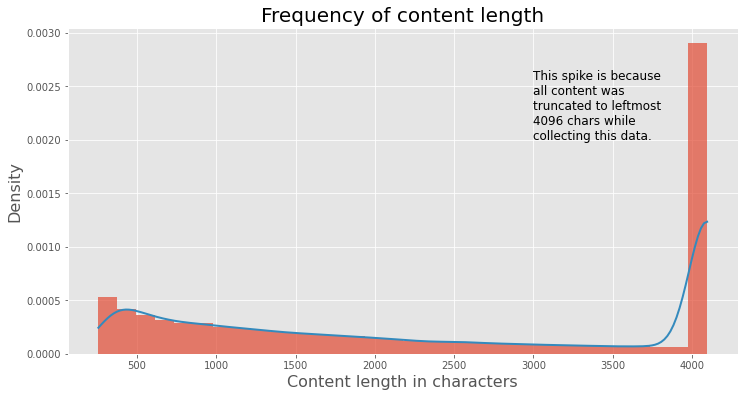

In [9]:
plt.figure(figsize = (12, 6))

plt.hist(filecontent_df['content_len'], bins = 32, density=True, alpha = 0.7, range = (MIN_CHAR_COUNT, MAX_CHAR_COUNT))

sns.kdeplot(filecontent_df['content_len'], clip = (MIN_CHAR_COUNT, MAX_CHAR_COUNT), linewidth = 2)

plt.text(
    3000, 0.002, 
    f"This spike is because \nall content was \ntruncated to leftmost \n{MAX_CHAR_COUNT} chars while \ncollecting this data.", 
    fontsize = 12)
plt.xlabel("Content length in characters", fontsize = 16)
plt.ylabel("Density", fontsize = 16)
plt.title("Frequency of content length", fontsize = 20)
plt.show()

In [10]:
avg_len_by_extn = filecontent_df.groupby("extension").agg({"content_len": np.mean}).sort_values("content_len")
avg_len_by_extn.round(1)

,content_len
extension,
llocs,517.2
pgm,582.1
geojson,790.8
meta,895.3
bb,973.6
...,...
ipynb,3793.2
vcproj,4017.4
vcxproj,4055.0


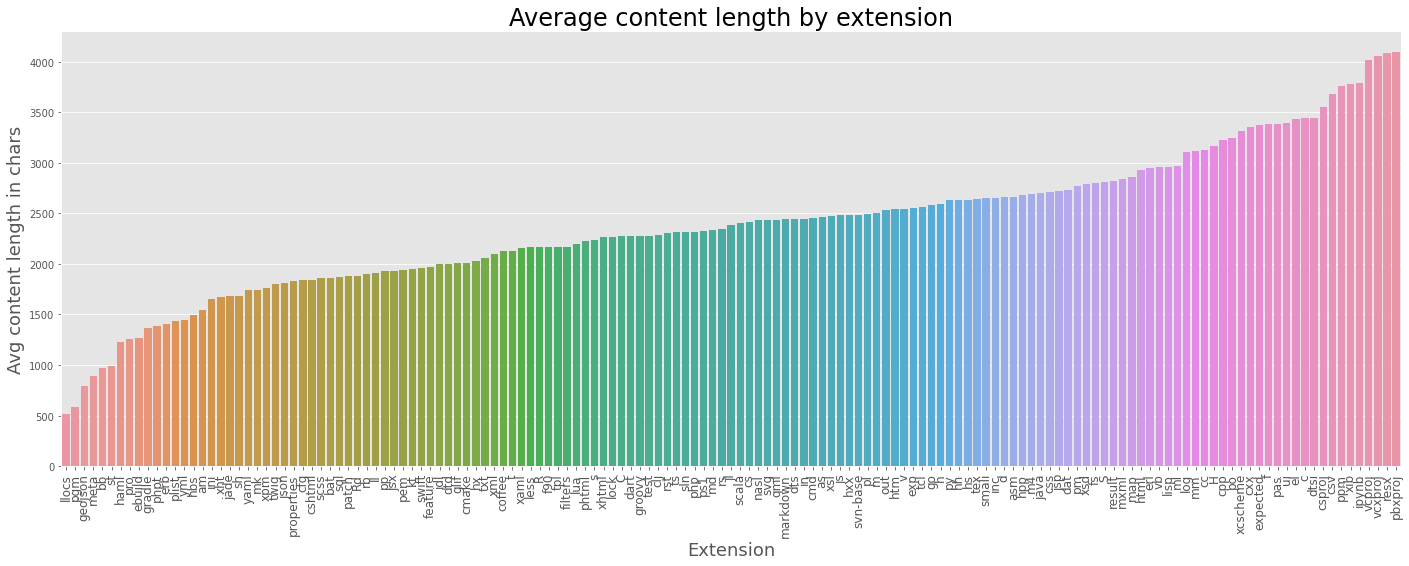

In [11]:
plt.figure(figsize = (24, 8))
sns.barplot(data = avg_len_by_extn, y = "content_len", x = avg_len_by_extn.index)
plt.xticks(range(len(avg_len_by_extn)), avg_len_by_extn.index, rotation = 90, fontsize = 12)
plt.xlabel("Extension", fontsize = 18)
plt.ylabel("Avg content length in chars", fontsize = 18)
plt.title("Average content length by extension", fontsize = 24)
plt.show()

### Symbols

#### Getting symbol count ratio with respect to content length

In [12]:
%%time

symbol_count_cols = []
symbol_prefix = configs["SYMBOL_COL_PREFIX"]

symbol_name_dict ={
    " ": f"{symbol_prefix}space",
    "\n": f"{symbol_prefix}NL",
    "\t": f"{symbol_prefix}tab"
}

for symbol in SYMBOLS:
    symbol_col_name = symbol_name_dict[symbol] if symbol in symbol_name_dict.keys() else f"{symbol_prefix}{symbol}"
        
    filecontent_df[symbol_col_name] = filecontent_df["content"].str.count(re.escape(symbol)) / filecontent_df["content_len"]
    symbol_count_cols.append(symbol_col_name)

filecontent_df.shape

Wall time: 1min


(388009, 61)

In [13]:
filecontent_df.sample(5)

,sample_path,content,extension,content_len,Ratio space,Ratio NL,Ratio tab,Ratio _,Ratio #,Ratio :,...,Ratio |,Ratio &&,Ratio ||,Ratio ^,Ratio (,Ratio ),Ratio {,Ratio },Ratio [,Ratio ]
5380,homage-sample/build.gradle,apply plugin: 'com.android.application'\n\nand...,gradle,717,0.207810,0.040446,0.000000,0.000000,0.000000,0.012552,...,0.000000,0.0,0.0,0.0,0.005579,0.005579,0.006974,0.006974,0.001395,0.001395
295738,bin/xray_trace_mysql.d,#!/usr/sbin/dtrace -s\n#pragma D option quiet\...,d,710,0.142254,0.042254,0.000000,0.005634,0.004225,0.011268,...,0.000000,0.0,0.0,0.0,0.005634,0.005634,0.002817,0.002817,0.000000,0.000000
132292,src/api.ts,"/// <reference path=""_ref.d.ts"" />\n\n'use str...",ts,1110,0.065766,0.036937,0.011712,0.000901,0.000000,0.002703,...,0.000000,0.0,0.0,0.0,0.015315,0.015315,0.000901,0.000901,0.000901,0.000901
111349,templates/components.hbs,---\nlayout: default.hbs\ntitle: Components\ns...,hbs,4096,0.144531,0.022949,0.000000,0.000244,0.000977,0.001953,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.003906,0.003906,0.000000,0.000000
75456,3rd/templight/llvm/test/Verifier/bitcast-addre...,; RUN: not llvm-as -disable-output %s 2>&1 | F...,ll,880,0.090909,0.014773,0.000000,0.000000,0.000000,0.038636,...,0.001136,0.0,0.0,0.0,0.017045,0.017045,0.005682,0.005682,0.000000,0.000000


In [14]:
filecontent_df.describe().round(2)

,content_len,Ratio space,Ratio NL,Ratio tab,Ratio _,Ratio #,Ratio :,Ratio ;,Ratio .,"Ratio ,",...,Ratio |,Ratio &&,Ratio ||,Ratio ^,Ratio (,Ratio ),Ratio {,Ratio },Ratio [,Ratio ]
count,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,...,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00,388009.00
mean,2390.04,0.15,0.03,0.01,0.01,0.00,0.01,0.01,0.02,0.01,...,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00
std,1482.94,0.09,0.02,0.02,0.01,0.02,0.01,0.01,0.02,0.02,...,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.00,0.00
min,256.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,923.00,0.09,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2220.00,0.14,0.03,0.00,0.00,0.00,0.00,0.00,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4096.00,0.20,0.04,0.00,0.01,0.00,0.01,0.01,0.02,0.01,...,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00
max,4096.00,0.95,0.54,0.48,0.47,0.61,0.72,0.97,0.93,1.00,...,0.35,0.14,0.08,0.38,0.19,0.57,0.27,0.14,0.18,0.16


#### Correlation between ratios of different symbols

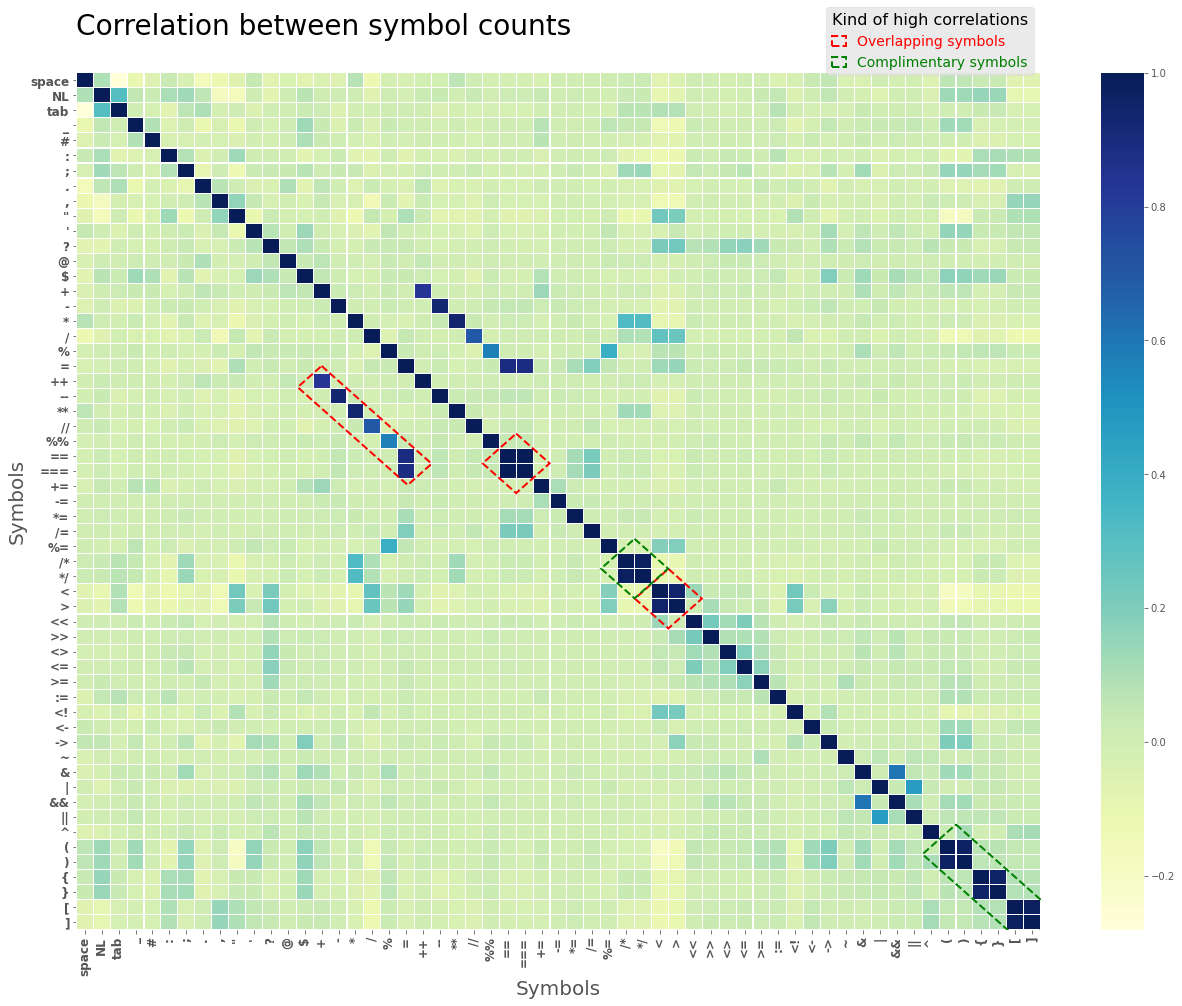

In [15]:
plt.figure(figsize = (18, 14))

ax = sns.heatmap(
    filecontent_df[symbol_count_cols].corr(),
    cmap = "YlGnBu",
    linewidths = 0.1
)

ax.set_xticklabels([col_name[len(symbol_prefix):] for col_name in symbol_count_cols], fontweight = "bold", fontsize = 12)
ax.set_yticklabels([col_name[len(symbol_prefix):] for col_name in symbol_count_cols], fontweight = "bold", fontsize = 12)

ax.add_patch(patches.Rectangle((14.5, 19.5), 9.2, 2, angle = 45, color = 'red', fill = False, linewidth = 2, linestyle = 'dashed'))
ax.add_patch(patches.Rectangle((26, 24), 2.8, 2.8, angle = 45, color = 'red', fill = False, linewidth = 2, linestyle = 'dashed'))
ax.add_patch(patches.Rectangle((35, 33), 2.8, 2.8, angle = 45, color = 'red', fill = False, linewidth = 2, linestyle = 'dashed'))

ax.add_patch(patches.Rectangle((33, 31), 2.8, 2.8, angle = 45, color = 'green', fill = False, linewidth = 2, linestyle = 'dashed'))
ax.add_patch(patches.Rectangle((52, 50), 8.5, 2.8, angle = 45, color = 'green', fill = False, linewidth = 2, linestyle = 'dashed'))

legend = ax.legend(
    ["Overlapping symbols", "Complimentary symbols"], 
    labelcolor = ['red', 'green'], 
    fontsize = 14, 
    title = 'Kind of high correlations',
    title_fontsize = 16, 
    loc = 'upper right', 
    handlelength = 1,
    bbox_to_anchor = (1, 1.085), 
    frameon = True
)
legend.legendHandles[0].set_color('red')
legend.legendHandles[1].set_color('green')

plt.title("Correlation between symbol counts\n", fontsize = 28, loc = 'left')
plt.xlabel("Symbols", fontsize = 20)
plt.ylabel("Symbols", fontsize = 20)
plt.tight_layout()
plt.savefig(
    f'{configs["PLOTS_BASE_PATH"]}Symbol_count_corr_heatmap.jpg', 
    dpi = configs["PLOTS_DPI"], 
    bbox_inches = 'tight', 
    facecolor = 'white'
)
plt.show()

## Saving processed data

In [16]:
filecontent_df.to_csv(f"{configs['OUTPUTS_BASE_PATH']}processed_filecontent.csv", index = False)